# Coresets with DPPs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

## Utils

### Data generation

In [2]:
# def get_hypercube_data(n,d, border=1, remove_subcube=False):
#     data = border*2*(np.random.rand(n, d) - .5)
#     if remove_subcube:
#         filtered_data = []
#         for point in data:
#             if (point < 0).any():
#                 filtered_data.append(point)
#         return np.array(filtered_data)
#     else:
#         return data

# def get_corners(d):
#     corners = []
#     for i in range(2**d):
#         corner = np.zeros(d)
#         for j in range(d):
#             if (i & (1 << j)) != 0: corner[j] = 1
#             else: corner[j] = -1
#         corners.append(corner)
#     return np.array(corners)

# def get_evenly_spaced_circle(radius, n_circles):
#     angles = 2*np.pi*np.arange(n_circles)/n_circles
#     means = np.stack((radius*np.cos(angles), radius*np.sin(angles)))
#     return means.T

# def get_cluster_data(n, d, k, variance=1/20, border=1):
#     if k<=2**d:
#         means = 0.6*get_corners(d)[:k]
#     covariances = [variance*np.identity(d) for i in range(k)]
#     data = []
#     for i in range(k):
#         data.extend(np.random.multivariate_normal(means[i], covariances[i], int(n/k)))
#     filtered_data = []
#     for point in data:
#         if (np.abs(point) < border).all():
#             filtered_data.append(point)
#     return np.array(filtered_data)

# def get_circle_data(n, d, n_circles, radius, variance=1/20, border=1):
#     means = get_evenly_spaced_circle(radius, n_circles)
#     covariances = [variance*np.identity(d) for i in range(n_circles)]
#     data = []
#     for i in range(n_circles):
#         data.extend(np.random.multivariate_normal(means[i], covariances[i], int(n/n_circles)))
#     filtered_data = []
#     for point in data:
#         if (np.abs(point) < border).all():
#             filtered_data.append(point)
#     return np.array(filtered_data)

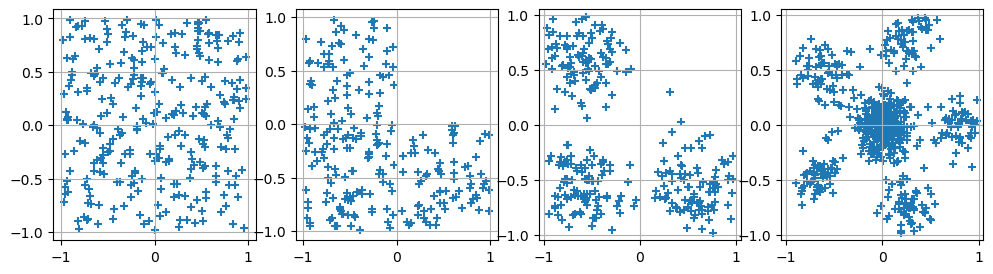

In [4]:
import utils

n, d, k = 300, 2, 3

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
X = utils.get_hypercube_data(n, d, border=.99)
plt.scatter(X[:,0], X[:,1], marker="+"), plt.grid()

plt.subplot(1,4,2)
X = utils.get_hypercube_data(n, d, border=.99, remove_subcube=True)
plt.scatter(X[:,0], X[:,1], marker="+"), plt.grid()

plt.subplot(1,4,3)
X = utils.get_cluster_data(n, d, k, border=.99)
plt.scatter(X[:,0], X[:,1], marker="+"), 
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim), plt.grid()

plt.subplot(1,4,4)
X1 = utils.get_circle_data(n, d, 5, radius=.8, variance=1/50, border=.99)
X2 = utils.get_circle_data(n, d, 1, radius=0, variance=1/50, border=.99)
X = np.concatenate((X1, X2))
plt.scatter(X[:,0], X[:,1], marker="+"), 
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim), plt.grid(), plt.show();

### Loss and error

In [69]:
from scipy.cluster.vq import vq

def risk(X, queries):
    code, dist = vq(X.reshape(-1, X.shape[-1]), queries)
    dist = dist.reshape(X.shape[:-1])
    return dist ** 2

def loss(X, query=np.zeros((1,X.shape[-1])), samples=None, weights=None):
    if samples is None:
        return risk(X, query).mean(-1)
    elif weights is None:
        return (risk(X[samples], query)).mean(-1)
    else:
        return (risk(X[samples], query) * weights).sum(-1)

def relative_error(y_hat, y):
    return np.abs(1 - y_hat / y)

### Sensitivity

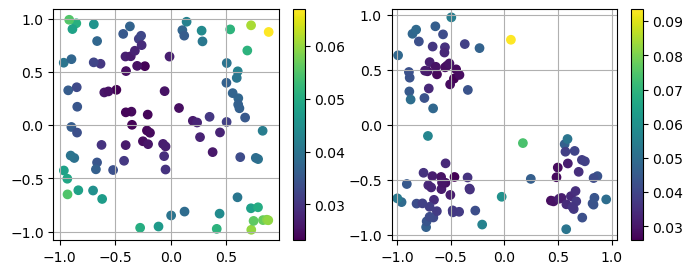

In [5]:
from itertools import combinations

def get_true_sensit(X, k):
    max_sensit_query = np.zeros(len(X))
    for combin in combinations(X, k):
        queries = combin
        risk_query = risk(X, queries)
        sensit_query = risk_query / risk_query.sum()
        max_sensit_query = np.maximum(max_sensit_query, sensit_query)
    return max_sensit_query

d, n, k = 2, 100, 3
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
X = get_hypercube_data(n, d)
sensit = get_true_sensit(X, 3)
plt.scatter(X[:,0], X[:,1], c=sensit)
plt.colorbar(), plt.grid()
plt.subplot(1,2,2)
X = get_cluster_data(n, d, k)
sensit = get_true_sensit(X, k)
plt.scatter(X[:,0], X[:,1], c=sensit)
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.colorbar(), plt.grid(), plt.show();

### Misc.

In [6]:
def plot3d_func(ax, func, nb_discr=100, cube_center=0, cube_halfsize=1.5):
    x, y = np.linspace(cube_center-cube_halfsize, cube_center+cube_halfsize, nb_discr), np.linspace(cube_center-cube_halfsize, cube_center+cube_halfsize, nb_discr)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx, yy]).transpose(1,2,0)
    zz =  func(xy.reshape(-1,2)).reshape(nb_discr,nb_discr)
    surf = ax.plot_surface(xx, yy, zz, cmap="viridis")

## Samplers

### OPE kernel

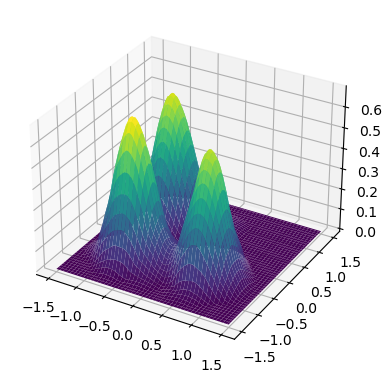

In [7]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))

plt.figure(figsize=(10,5))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)

In [64]:
from dppy.multivariate_jacobi_ope import MultivariateJacobiOPE
from sklearn.neighbors import KernelDensity
from dppy.finite_dpps import FiniteDPP
from scipy.linalg import svd

def draw_OPE(X, m, nb_samples, ab_coeff=-.5, gamma_X=None, prop_uniform=0): 
    # complexity is n^2*m^2 if gamma_X is None then KDE needs to be computed, else n*m^2 
    n = len(X)
    m = int(m)
    if gamma_X is None: # /!\ induce n^2 complexity
        # construct gamma tilde KDE estimation
        # alternatively, scipy.stats.gaussian_kde can be used
        kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
        gamma_X = np.exp(kde.score_samples(X))

    # handle a proportion of samples drawn uniformly
    nb_total_uniform = round(prop_uniform * n)
    nb_sample_uniform = round(prop_uniform * m)
    if nb_total_uniform>0:
        m -= nb_sample_uniform
        argsort_X = np.argsort(gamma_X)
        uniform_idX = argsort_X[:nb_total_uniform]
        OPE_idX = argsort_X[nb_total_uniform:]
        X_OPE = X[OPE_idX]
        gamma_X_OPE = gamma_X[OPE_idX] 
    else:
        X_OPE = X
        gamma_X_OPE = gamma_X

    # obtain P which decompose continuous DPP K = PP^T
    ab_coeff_array = np.zeros((d,2)) + ab_coeff
    dpp = MultivariateJacobiOPE(m, ab_coeff_array)
    polynom_X = dpp.eval_multiD_polynomials(X_OPE)
    ref_measure_X = dpp.eval_w(X_OPE)
    P = np.sqrt(ref_measure_X / gamma_X_OPE)[:,None] * polynom_X

    # extract m eigenvectors of K by SVD of P
    U, S, Vh = svd(P, full_matrices=False)
    eig_vals, eig_vecs = np.ones(m), U
    diag_K_tilde = (U**2).sum(-1)
    OPE_weights = (1 / n) / diag_K_tilde

    # draw from OPE
    DPP = FiniteDPP(kernel_type='correlation', projection=True, K_eig_dec=(eig_vals, eig_vecs))
    for _ in range(nb_samples):
        DPP.sample_exact(mode='GS')
    OPE_samples = np.array(DPP.list_of_samples, dtype=int)

    # return samples and associated weights
    if nb_sample_uniform>0:
        weights = np.zeros(n)
        weights[OPE_idX] = OPE_weights
        weights[uniform_idX] =  nb_total_uniform / (n * nb_sample_uniform)
        # draw nb_sample_uniform samples uniformly
        uniform_samples = np.random.choice(uniform_idX, (nb_samples, nb_sample_uniform))
        # concatenate OPE and uniform
        samples = np.concatenate((OPE_idX[OPE_samples], uniform_samples), axis=-1)
        return samples, weights[samples]
    else:
        return OPE_samples, OPE_weights[OPE_samples]

### Discrete OPE kernel

In [9]:
import itertools
from scipy.linalg import qr

def compute_ordering(m, d):
    layer_max = np.floor(m**(1.0 / d)).astype(np.int16)
    ordering = itertools.chain.from_iterable(
                filter(lambda x: k in x,
                       itertools.product(range(k + 1), repeat=d))
                for k in range(layer_max + 1))
    return np.array(list(ordering)[:m])

def draw_discrete_OPE(X, m, nb_samples):
    # compute discrete OPE kernel
    ordering = compute_ordering(m, X.shape[-1])
    vander_matrix = np.prod(X[:,None,:]**ordering, axis=-1)
    q_matrix, r_matrix = qr(vander_matrix, mode="economic")
    eig_vals, eig_vecs = np.ones(m), q_matrix
    diag_K_tilde = (q_matrix**2).sum(-1)
    weights = (1 / n) / diag_K_tilde

    # draw from discrete OPE
    DPP = FiniteDPP(kernel_type='correlation', projection=True, K_eig_dec=(eig_vals, eig_vecs))
    for _ in range(nb_samples):
        DPP.sample_exact(mode='GS')
    samples = np.array(DPP.list_of_samples)
    return samples, weights[samples]

### Gaussian kernel k-DPP

In [10]:
def gaussian_kernel(X, sigma=1):
    delta = X[:,None,:] - X[None,:,:]
    K = np.exp(-0.5 * np.sum(delta**2, axis=-1) / sigma**2)
    return K

def elementary_symmetric_polynomial(k, arr):
    n = len(arr)
    esp_eval = np.zeros((n+1,k+1))
    esp_eval[:,0] = np.ones(n+1)
    for i in range(1,k+1):
        for j in range(1,n+1):
            esp_eval[j,i] = esp_eval[j-1,i] + arr[j-1] * esp_eval[j-1,i-1]
    return esp_eval[-1,-1]

def get_kDPP_weights(likelihood, k):
    n = len(likelihood)
    U, S, Vh = svd(likelihood)
    eigvals = S**2
    elem_sym_pol_ratio = np.empty(n)
    for i_eigval, eigval in enumerate(eigvals):
        e_mn_kmo = elementary_symmetric_polynomial(k-1, np.concatenate((eigvals[:i_eigval], eigvals[i_eigval+1:])))
        e_n_k = elementary_symmetric_polynomial(k, eigvals)
        elem_sym_pol_ratio[i_eigval] = e_mn_kmo / e_n_k
    return (1 / n) / ((U)**2 * eigvals * elem_sym_pol_ratio).sum(-1)
    
def draw_gaussian_kDPP(X, m, nb_samples, bandwidth=1):
    likelihood = gaussian_kernel(X, bandwidth)
    weights = get_kDPP_weights(likelihood, m)
    DPP = FiniteDPP(kernel_type='likelihood', L= likelihood)
    for _ in range(nb_samples):
        DPP.sample_exact_k_dpp(m, mode='GS')
    samples = np.array(DPP.list_of_samples)
    return samples, weights[samples]


approximately m=5.000


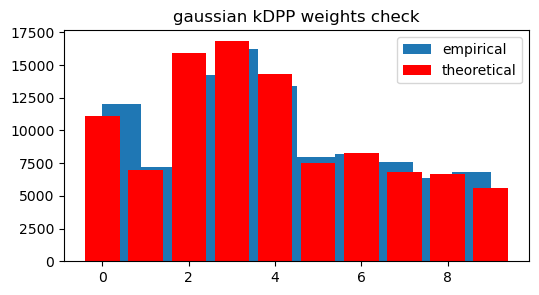

In [11]:
d, n, m, k = 2, 10, 5, 3
nb_samples = 20000
X = get_hypercube_data(n, d, border=.99)
bandwidth = 1

likelihood = gaussian_kernel(X, bandwidth)
weights = get_kDPP_weights(likelihood, m)
samples, _ = draw_gaussian_kDPP(X, m, nb_samples, bandwidth)
samples = samples.flatten()
print(f"approximately m={(1/(n*weights)).sum():.3f}")
plt.figure(figsize=(6,3))
plt.hist(samples, density=False, label="empirical")
plt.bar(np.arange(len(X)), nb_samples/(n*weights), color='r', label="theoretical")
plt.title("gaussian kDPP weights check"), plt.legend();

### i.i.d. uniform

In [12]:
def draw_uniform(n, m, nb_samples):
    return np.random.choice(n, (nb_samples, m))

### Sensitivity

In [13]:
from scipy.spatial import distance
from scipy.cluster.vq import vq

def D_squared_sampling(X, k):
    n = len(X)
    B = np.zeros(k, dtype=int)
    B[0] = np.random.choice(n)
    sqdist_to_B = np.full(n, np.inf)
    for i in range(1,k):
        sqdist_to_sample = distance.cdist(X[None,B[i-1]], X, 'sqeuclidean')[0]
        sqdist_to_B = np.minimum(sqdist_to_B, sqdist_to_sample)
        sample = np.random.choice(n, p=sqdist_to_B/sqdist_to_B.sum())
        B[i] = sample
    return B        

def best_quant(X, k, delta):
    n_runs = np.ceil(10*np.log(1/delta)).astype(int)
    quant_error_min = np.inf
    for run in range(n_runs):
        B = D_squared_sampling(X, k)
        code, dist = vq(X, X[B])
        quant_error = (dist**2).sum()
        if quant_error < quant_error_min:
            quant_error_min = quant_error
            code_min, dist_min = code, dist
    return code_min, dist_min

def kmean_sensit_ub(X, k, delta):
    code, dist = best_quant(X, k, delta)
    alpha = 16*(np.log(k) + 2)
    n = len(X)
    c_phi = 1/n * dist.sum()
    count_B = np.zeros(k, dtype=int)
    dist_B = np.zeros(k)
    for i, c in enumerate(code):
        count_B[c] += 1
        dist_B[c] += dist[i]
    sensit_ub = alpha*dist/c_phi + 2*alpha*dist_B[code]/(count_B[code]*c_phi) + 4*n/count_B[code]
    return sensit_ub

def get_sensit_sample(X, m, k, delta):
    n = len(X)
    sensit_ub = kmean_sensit_ub(X, k, delta)
    sensit_proba = sensit_ub/sensit_ub.sum()
    samples = np.random.choice(n, m, p=sensit_proba)
    weights = 1/(sensit_proba[samples]*m*n)
    return samples, weights

def draw_sensitivity(X, m, nb_samples, k, delta):
    samples, weights = np.empty((nb_samples, m), dtype=int), np.empty((nb_samples, m))
    for i_sample in range(nb_samples):
        samples[i_sample], weights[i_sample] = get_sensit_sample(X, m, k, delta)
    return samples, weights

### Stratified

In [14]:
from collections import defaultdict

def shuffle_cycle_array(uncompleted_stratas, m):
    completed_stratas = []
    for count in range(m):
        if count == len(uncompleted_stratas):
            np.random.shuffle(uncompleted_stratas)
        completed_stratas.append(uncompleted_stratas[count % len(uncompleted_stratas)])
    return completed_stratas

def draw_stratified(X, m, nb_samples):
    box_length = m**(-1/d)
    # build stratas
    stratas = defaultdict(list)
    for i_x, x in enumerate((X+1)/2):
        key = ""
        for dim in range(d):
            key += str(int(x[dim]//box_length))
        stratas[key].append(i_x)
    stratas = np.array(list(stratas.values()), dtype=object)
    nb_stratas = len(stratas)
    # sample from each strata
    strata_samples = np.empty((nb_samples, nb_stratas), dtype=int)
    samples = np.empty((nb_samples, m), dtype=int)
    if nb_stratas<m:
        # print(f"/!\ m={m} but there are only {nb_stratas} stratas. Try increase n or reduce m.")
        for i_sample in range(nb_samples):
            completed_stratas = shuffle_cycle_array(stratas, m)
            for i_strata, strata in enumerate(completed_stratas):
                samples[i_sample,i_strata] = np.random.choice(strata)
        return samples
    for i_strata, strata in enumerate(stratas):
        strata_samples[:,i_strata] = np.random.choice(strata, nb_samples)
    if nb_stratas==m:
        return strata_samples
    else:  # extract m stratas for each samples
        for i_strata_sample, strata_sample in enumerate(strata_samples):
            samples[i_strata_sample] = np.random.choice(strata_sample, m, replace=False)
    return samples

### Sampling example

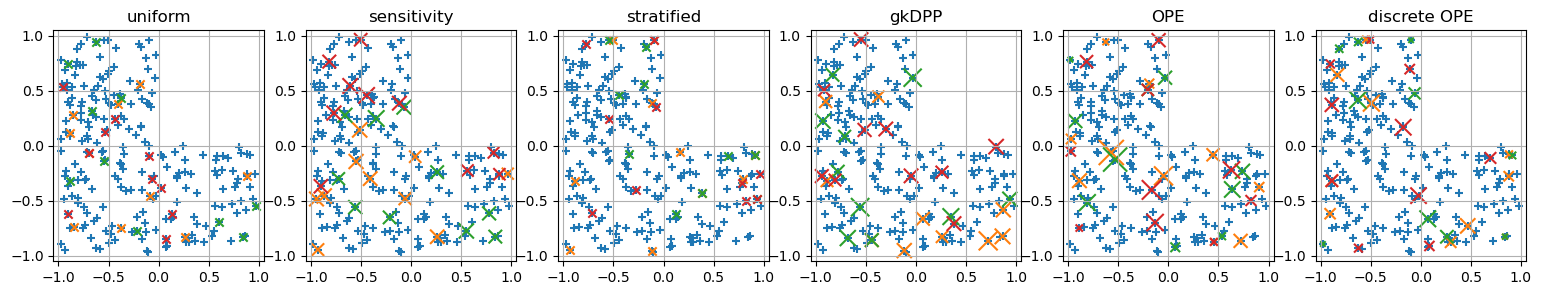

In [15]:
d, n, m, k = 2, 300, 10, 3
nb_samples = 3
X = get_hypercube_data(n, d, border=.99, remove_subcube=True)
# X = get_cluster_data(n, d, k, variance=1/10, border=.99)
# X1 = get_circle_data(n/3, d, 3, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
bandwidth = .1

uniform_samples = draw_uniform(len(X), m, nb_samples)
X_uniform = X[uniform_samples]
sensit_samples, sensit_weights = draw_sensitivity(X, m, nb_samples, k, .1)
X_sensit = X[sensit_samples]
stratified_samples = draw_stratified(X, m, nb_samples)
X_stratified = X[stratified_samples]
gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, nb_samples, bandwidth)
X_gkDPP = X[gkDPP_samples]
OPE_samples, OPE_weights = draw_OPE(X, m, nb_samples, ab_coeff=0, prop_uniform=.1)
X_OPE = X[OPE_samples]
dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, nb_samples)
X_dOPE = X[dOPE_samples]

titles = ["uniform","sensitivity","stratified","gkDPP","OPE","discrete OPE"]
weights = [None, sensit_weights, None, gkDPP_weights, OPE_weights, dOPE_weights]
plt.figure(figsize=(19,3))
for k, X_samples in enumerate([X_uniform, X_sensit, X_stratified, X_gkDPP, X_OPE, X_dOPE]):
    plt.subplot(1,len(titles),k+1)
    plt.scatter(X[:,0], X[:,1], marker='+')
    for i_sample in range(nb_samples):
        weight = None
        if weights[k] is not None: weight= 100*m*weights[k][i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight)
    xylim = 1.05
    plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim), plt.title(titles[k]), plt.grid()
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])

## Statistics

### Variance rate

In [75]:
d, desired_n, k = 2, 200, 3    # 2, 1024, 3
X = get_hypercube_data(desired_n, d, border=.99, remove_subcube=True)
# X = get_cluster_data(desired_n, d, k, variance=1/4, border=.99)
# X1 = get_circle_data(10, d, 1, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(desired_n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
n = len(X)
print(f"obtained n={n}")

kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
kde_distr = np.exp(kde.score_samples(X)) # .25 in uniform case
nb_rep = 500
# queries = X[np.random.choice(n, (3,k), replace=False)]
queries = np.zeros((1,1,X.shape[-1]))
# ms = np.round(np.logspace(1, 6, num=10, base=2)).astype(int)
ms = np.arange(1,10, dtype=int)**2 # (1,14)
print(f"m list={ms}")
SE_means, SE_stds, relerrs = [], [], []
loss_X = loss(X)
nb_ms, nb_queries = len(ms), len(queries)

for id_query, query in enumerate(queries):
    # draw queries
    print(f"draw query {id_query+1}/{nb_queries}")

    for m in ms:
        print(f"m={m}")
        # sample
        uniform_samples = draw_uniform(n, m, nb_rep)
        sensit_samples, sensit_weights = draw_sensitivity(X, m, nb_rep, k, delta=.1)
        stratified_samples = draw_stratified(X, m, nb_rep)
        gkDPP_samples, gkDPP_weights = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=.1)
        OPE_samples, OPE_weights = draw_OPE(X, m, nb_rep, gamma_X=kde_distr, prop_uniform=0)
        dOPE_samples, dOPE_weights = draw_discrete_OPE(X, m, nb_rep)

        # compute loss
        loss_uniform = loss(X, query, samples=uniform_samples)
        loss_sensit = loss(X, query, sensit_samples, sensit_weights)
        loss_stratified = loss(X, query, stratified_samples)
        loss_gkDPP = loss(X, query, gkDPP_samples, gkDPP_weights)
        loss_OPE = loss(X, query, OPE_samples, OPE_weights)
        loss_dOPE = loss(X, query, dOPE_samples, dOPE_weights)

        # compute metrics
        loss_samples = np.array([loss_uniform, loss_sensit, loss_stratified, loss_gkDPP, loss_OPE, loss_dOPE])
        SEs = (loss_samples - loss_X)**2
        SE_means.append(SEs.mean(-1))
        SE_stds.append(SEs.std(-1))
        relerrs.append(relative_error(loss_samples, loss_X))

relerrs_sup = np.array(relerrs).reshape(nb_queries, nb_ms, -1, nb_rep).max(0)
SE_means, SE_stds = np.array(SE_means).reshape(nb_queries, nb_ms, -1), np.array(SE_stds).reshape(nb_queries, nb_ms, -1)
SE_means_argmax = SE_means.argmax(0)
arr1, arr2 = np.ogrid[:nb_ms,:SE_means.shape[-1]]
SE_means_sup = SE_means[SE_means_argmax, arr1, arr2]
SE_stds_sup = SE_stds[SE_means_argmax, arr1, arr2]

obtained n=148
m list=[ 1  4  9 16 25 36 49 64 81]
draw query 1/1
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81


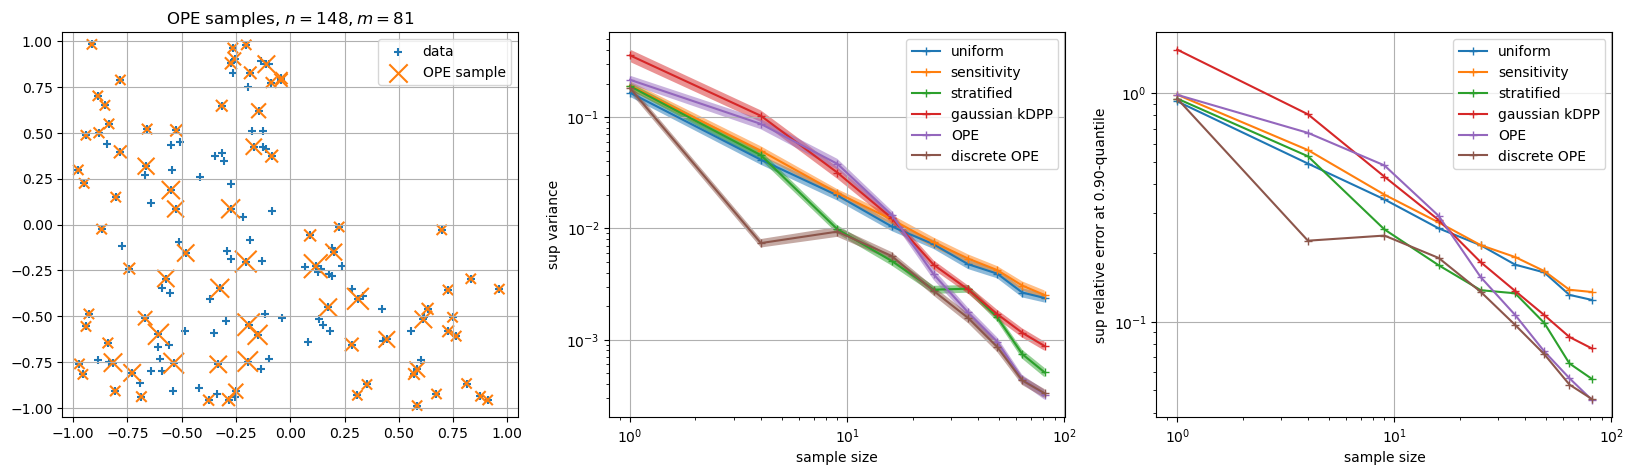

In [76]:
nb_stds = 1.5*nb_rep**(-.5)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], marker="+", label="data")
X_samples = X[OPE_samples[0]]
plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label="OPE sample", s=100*m*OPE_weights[0])
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.title(f"OPE samples, $n={n}, m={m}$"), plt.legend(), plt.grid()

plt.subplot(132)
legends = ["uniform","sensitivity","stratified","gaussian kDPP","OPE", "discrete OPE"]
plt.plot(ms, SE_means_sup, label=legends, marker="+")
for k, legend in enumerate(legends):
    plt.fill_between(ms, SE_means_sup[:,k]+nb_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-nb_stds*SE_stds_sup[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup variance")
plt.legend(), plt.grid()

plt.subplot(133)
delta1, delta2 = .1, .01
relerr_quant1, relerr_quant2 = np.quantile(relerrs_sup, 1-delta1, axis=-1), np.quantile(relerrs_sup, 1-delta2, axis=-1)
plt.plot(ms, relerr_quant1, label=legends, marker="+")
# for k, legend in enumerate(legends):
#     plt.fill_between(ms, relerr_quant1[:,k], relerr_quant2[:,k], alpha=.5)
# plt.boxplot(relerrs_sup[:,2].T, positions=ms, widths=.1*ms)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"sup relative error at {1-delta1:.2f}-quantile")
plt.legend(), plt.grid(), plt.show();

In [37]:
d, n, k = 2, 700, 3    # 2, 1024, 3
X = get_hypercube_data(n, d, border=.99, remove_subcube=True)
# X = get_cluster_data(n, d, k, variance=1/4, border=.99)
# X1 = get_circle_data(n/3, d, 3, radius=.8, variance=1/300, border=.99)
# X2 = get_circle_data(n, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))

kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
oracle_distr = np.exp(kde.score_samples(X)) # .25 in uniform case
nb_rep, nb_query = 500, None

# ms = np.round(np.logspace(1, 6, num=10, base=2)).astype(int)
ms = np.arange(1, 8)**2 # (1,14)
bandwiths = [.001, .01, .05, .1, .7]
print(ms)
SE_means, SE_stds, relerrs = [], [], []
loss_X = loss(X)

for m in ms:
    print(f"m={m}")
    # sample
    uniform_samples = draw_uniform(len(X), m, nb_rep)
    gkDPP_samples1, gkDPP_weights1 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[0])
    gkDPP_samples2, gkDPP_weights2 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[1])
    gkDPP_samples3, gkDPP_weights3 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[2])
    gkDPP_samples4, gkDPP_weights4 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[3])
    gkDPP_samples5, gkDPP_weights5 = draw_gaussian_kDPP(X, m, nb_rep, bandwidth=bandwiths[4])
    # compute loss
    loss_uniform = loss(X, samples=uniform_samples)
    loss_gkDPP1 = loss(X, samples=gkDPP_samples1, weights=gkDPP_weights1[gkDPP_samples1])
    loss_gkDPP2 = loss(X, samples=gkDPP_samples2, weights=gkDPP_weights2[gkDPP_samples2])
    loss_gkDPP3 = loss(X, samples=gkDPP_samples3, weights=gkDPP_weights3[gkDPP_samples3])
    loss_gkDPP4 = loss(X, samples=gkDPP_samples4, weights=gkDPP_weights4[gkDPP_samples4])
    loss_gkDPP5 = loss(X, samples=gkDPP_samples5, weights=gkDPP_weights5[gkDPP_samples5])
    loss_samples = np.array([loss_uniform, loss_gkDPP1, loss_gkDPP2, loss_gkDPP3, loss_gkDPP4, loss_gkDPP5])
    # compute metrics
    SEs = (loss_samples - loss_X)**2
    SE_means.append(SEs.mean(-1))
    SE_stds.append(SEs.std(-1))
    relerrs.append(relative_error(loss_samples, loss_X))
relerrs = np.array(relerrs)
SE_means, SE_stds = np.array(SE_means), np.array(SE_stds)

[ 1  4  9 16 25 36 49]
m=1
m=4
m=9
m=16
m=25
m=36
m=49


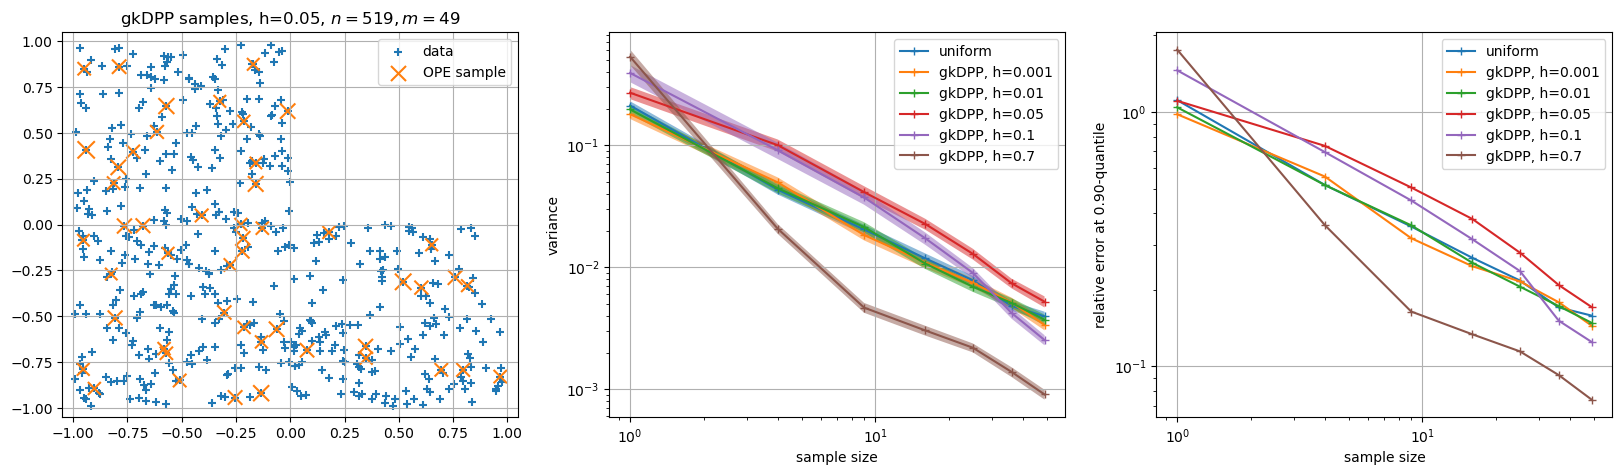

In [38]:
nb_stds = 1.5*nb_rep**(-.5)
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], marker="+", label="data")
DPP_sample = gkDPP_samples3[0]
plt.scatter(X[DPP_sample,0],X[DPP_sample,1], marker="x", label="OPE sample", s=100*m*gkDPP_weights3[DPP_sample])
xylim = 1.05
plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
plt.title(f"gkDPP samples, h={bandwiths[2]}, $n={len(X)}, m={m}$"), plt.legend(), plt.grid()

plt.subplot(132)
legends = ["uniform"]+["gkDPP, h="+str(bandwith) for bandwith in bandwiths]
plt.plot(ms, SE_means, label=legends, marker="+")
for k, legend in enumerate(legends):
    plt.fill_between(ms, SE_means[:,k]+nb_stds*SE_stds[:,k], SE_means[:,k]-nb_stds*SE_stds[:,k], alpha=.5)
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("variance")
plt.legend(), plt.grid()

plt.subplot(133)
delta1, delta2 = .1, .01
relerr_quant1, relerr_quant2 = np.quantile(relerrs, 1-delta1, axis=-1), np.quantile(relerrs, 1-delta2, axis=-1)
plt.plot(ms, relerr_quant1, label=legends, marker="+")
plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"relative error at {1-delta1:.2f}-quantile")
plt.legend(), plt.grid(), plt.show();

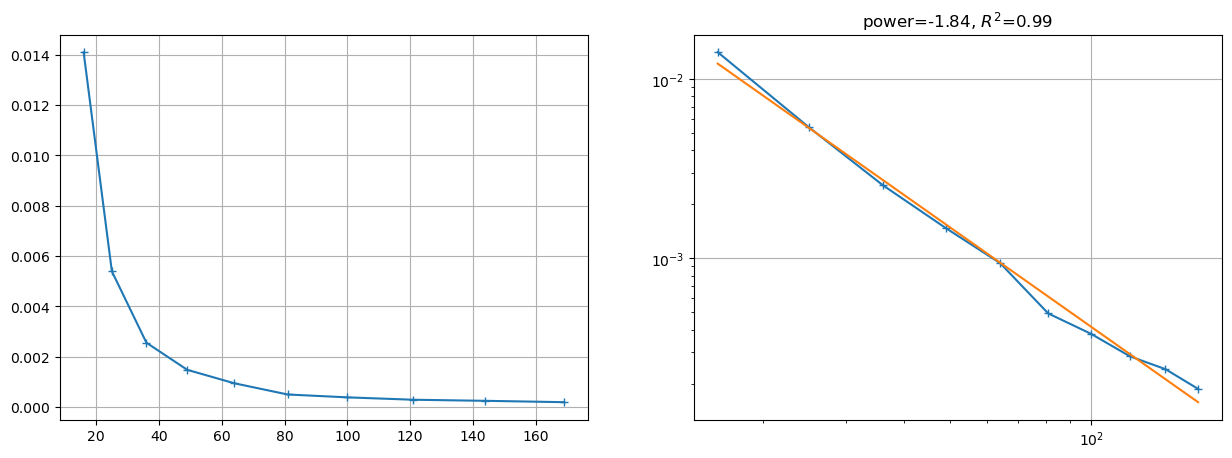

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

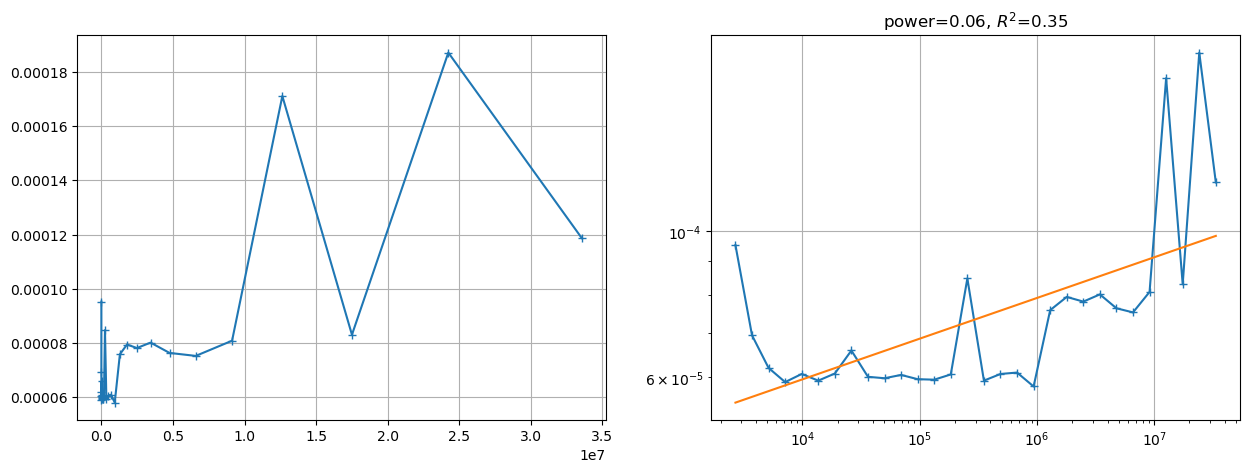

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], nb_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))